In [181]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [182]:
import pandas as pd 
import matplotlib.pyplot as plt

path = "bank.csv"
df = pd.read_csv(path, sep=',')

df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
5,42,management,single,tertiary,no,0,yes,yes,unknown,5,may,562,2,-1,0,unknown,yes
6,56,management,married,tertiary,no,830,yes,yes,unknown,6,may,1201,1,-1,0,unknown,yes
7,60,retired,divorced,secondary,no,545,yes,no,unknown,6,may,1030,1,-1,0,unknown,yes
8,37,technician,married,secondary,no,1,yes,no,unknown,6,may,608,1,-1,0,unknown,yes
9,28,services,single,secondary,no,5090,yes,no,unknown,6,may,1297,3,-1,0,unknown,yes


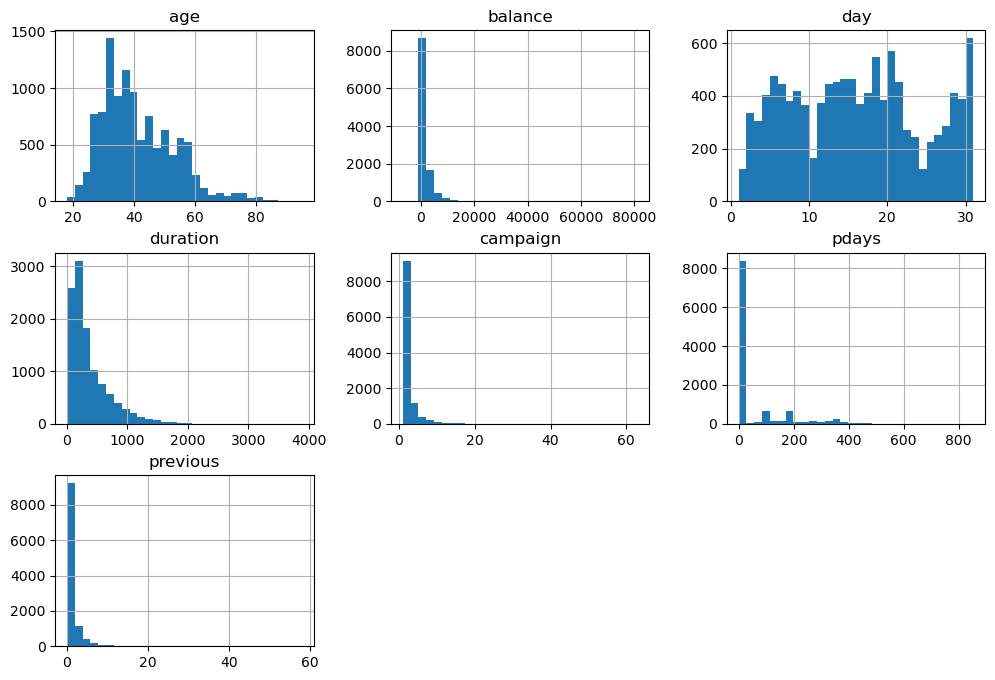

In [183]:
df.hist(bins=30, figsize=(12,8))
plt.show()

Przygotowanie danych:

- skaluje kolumny numeryczne
- zamieniam kategorie na 0/1
- x-reszta, y-deposit

In [184]:
for col in ['default', 'housing', 'loan', 'deposit']:
  df[col] = df[col].map({'yes': 1, 'no': 0})

X = df.drop('deposit', axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

pre = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
])

Model

In [185]:
model = Pipeline([
    ('preprocessing', pre),
    ('classifier', LogisticRegression(max_iter=1000))
])

model.fit(X_train, y_train)

y_proba = model.predict_proba(X_test)[:, 1]

tres = [0.1, 0.25, 0.5, 0.75, 0.9]
rows = []

for t in tres:
    y_pred = (y_proba >=t).astype(int)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    rows.append({
        'Threshold': t,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'TP' : tp,
        'FP': fp,
        'TN': tn,
        'FN': fn,
        'TPR': tpr,
        'FPR': fpr
    })

res = pd.DataFrame(rows)
print(res)

   Threshold  Accuracy  Precision    Recall  F1-Score    TP   FP    TN   FN  \
0       0.10  0.641738   0.569805  0.995274  0.724708  1053  795   380    5   
1       0.25  0.802508   0.720200  0.953686  0.820659  1009  392   783   49   
2       0.50  0.825347   0.828094  0.796786  0.812139   843  175  1000  215   
3       0.75  0.766682   0.887446  0.581285  0.702456   615   78  1097  443   
4       0.90  0.676668   0.917910  0.348771  0.505479   369   33  1142  689   

        TPR       FPR  
0  0.995274  0.676596  
1  0.953686  0.333617  
2  0.796786  0.148936  
3  0.581285  0.066383  
4  0.348771  0.028085  


Liczymy recznie koszt, przy koszcie FP = 10, FN = 3:

- 0.1: 10x795 + 5x3 = 7965
- 0.25 = 4067
- 0.5: 2395
- 0.75: 2109
- 0.9: 2397

czyli optymalny 0.75 

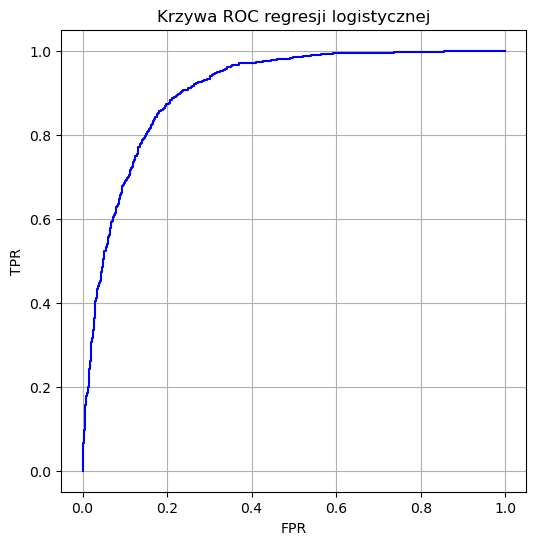

In [186]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Krzywa ROC regresji logistycznej')
plt.grid(True)
plt.show()

In [187]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

sel = SelectKBest(score_func=mutual_info_classif, k=2)
model2 = Pipeline([
    ('preprocessing', pre),
    ('feature_selection', sel),
    ('classifier', LogisticRegression(max_iter=1000))
])
model2.fit(X_train, y_train)

pre_fit = model2.named_steps['preprocessing']
sel_fit = model2.named_steps['feature_selection'] 

feat_names = pre_fit.get_feature_names_out() 
scores = sel_fit.scores_ 

top2_idx = np.argsort(scores)[-2:][::-1]     
best2 = [feat_names[i] for i in top2_idx]

print("Najlepsze 2 predyktory:", best2)

Najlepsze 2 predyktory: ['num__duration', 'num__pdays']


In [188]:
X2 = df[['duration', 'pdays']]
y2 = df['deposit']

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42, stratify=y2
)

scaler = StandardScaler()
X2_train_s = scaler.fit_transform(X2_train)
X2_test_s  = scaler.transform(X2_test)

clf2 = LogisticRegression(max_iter=1000)
clf2.fit(X2_train_s, y2_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


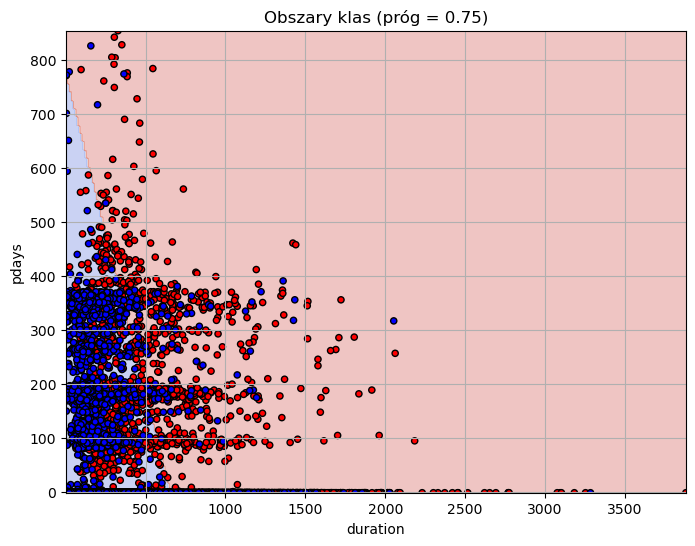

In [189]:
x_min, x_max = X2['duration'].min(), X2['duration'].max()
y_min, y_max = X2['pdays'].min(),    X2['pdays'].max()

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

X_grid_df = pd.DataFrame({
    'duration': xx.ravel(),
    'pdays':    yy.ravel()
})

X_grid_scaled = scaler.transform(X_grid_df)

THRESH = 0.75
proba = clf2.predict_proba(X_grid_scaled)[:, 1]
Z = (proba >= THRESH).astype(int).reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
#czerwone - 1, niebieskie - 0
plt.scatter(X2['duration'], X2['pdays'], c=y2, cmap='bwr', edgecolor='k', s=20)
plt.xlabel('duration')
plt.ylabel('pdays')
plt.title(f'Obszary klas (próg = {THRESH})')
plt.grid(True)
plt.show()
